# Group Members
- Genovese Francesco
- Jagarlapoodi Srinivas
- Malavita Daniela
- Mioli Riccardo
- Santini Guglielmo

# Home Credit Default Risk
The project consist in a binary classification problem, the two classes to be predicted are: people that will pay back a loan and people that will not pay back.  

The data is provided by Home Credit, a financial company funded in 1997 that provides various financial services. Home Credit operates in countries such as: Czech Republic, Slovakia, Kazakhstan, Vietnam, etc. In these countries people often do not have an established credit histroy, therefore Home Credit tries to leverage various kind of data to predict whether a person is financially stable or not.  

Few .csv files are given to be used for the classification task, the operations performed on each file will be discussed in the subsequent sections.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler, BorderlineSMOTE, ADASYN
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.feature_selection import f_regression, SelectPercentile, mutual_info_classif, f_classif
from sklearn.preprocessing import Normalizer, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
import seaborn as sns

# This function is used to plot the percentage of missing values for each column of the dataframe that will be passed as input.
def na_status(dataset: pd.DataFrame):
    shape = dataset.shape
    na_data = dataset.isna().sum().to_frame(name="na_count")
    if na_data.sum()[0] > 0:
        display("Dataset has %i rows and %i columns." % shape)
        display(dataset.head())
        display(na_data.transpose())
        na_data = na_data[na_data["na_count"] > 0]
        na_data.sort_values(ascending=True, by="na_count", inplace=True)
        plt.figure(figsize=(5, na_data.shape[0]*0.2))
        x = na_data["na_count"]/shape[0] #Number of nas in percentage
        plt.barh(y=na_data.index,
                 width=x, height=0.3)
        # If more or equal that 50% of values are missing, draw a red vline
        if x.max() >= 0.5:
            plt.axvline(0.5, color="r")
        plt.title("Percentage of missing values per column.")
        plt.xlabel("% of missing.")
        plt.ylabel("Col. name.")
        plt.show()
    else:
        print("No na values")


In [15]:
BASE_PATH = "./home-credit-default-risk"

np.random.seed(42)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#IDs we will use in the groupbys. id_curr represent the loan a client is asking "today", id_prev 
#represent loans requested in the past.
id_curr = "SK_ID_CURR"
id_prev = "SK_ID_PREV"


## Data Preparation - New columns and data integration
The file named `application_train.csv` contains data asked to people that are requesting a loan. This file contains also an id that will be used to merge the current application data with other files and the binary target to be learned.  

The data requested during the application is about: the gender, car data, the count of children, the income of the person, the amount of requested credit, etc.  
The dataframe has a lot of missing values regarding the house of the person that is requiring the loan, in this case a new column containing a new "syntetic" indicator of how much information about the house of the person is available has been created. This can be thought as a proxy of how much this person disclosed of his property.  
A similar operation was performed on car data, in this case the variable has been discretized as a binary one where 0 is "no data available" and 1 is "data is available".  

At the end, the original data from which the new data was created was deleted and unavailable values were filled with 0.  

'Dataset has 307511 rows and 121 columns.'

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,N

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
na_count,0,0,0,0,0,0,0,0,12,278,1292,0,0,0,0,0,0,0,0,0,202929,0,0,0,0,0,0,96391,2,0,0,0,0,0,0,0,0,0,0,0,173378,660,60965,156061,179943,150007,204488,214865,163891,154828,153020,208642,182590,210199,154350,213514,169682,156061,179943,150007,204488,214865,163891,154828,153020,208642,182590,210199,154350,213514,169682,156061,179943,150007,204488,214865,163891,154828,153020,208642,182590,210199,154350,213514,169682,210295,154297,148431,156341,145755,1021,1021,1021,1021,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41519,41519,41519,41519,41519,41519


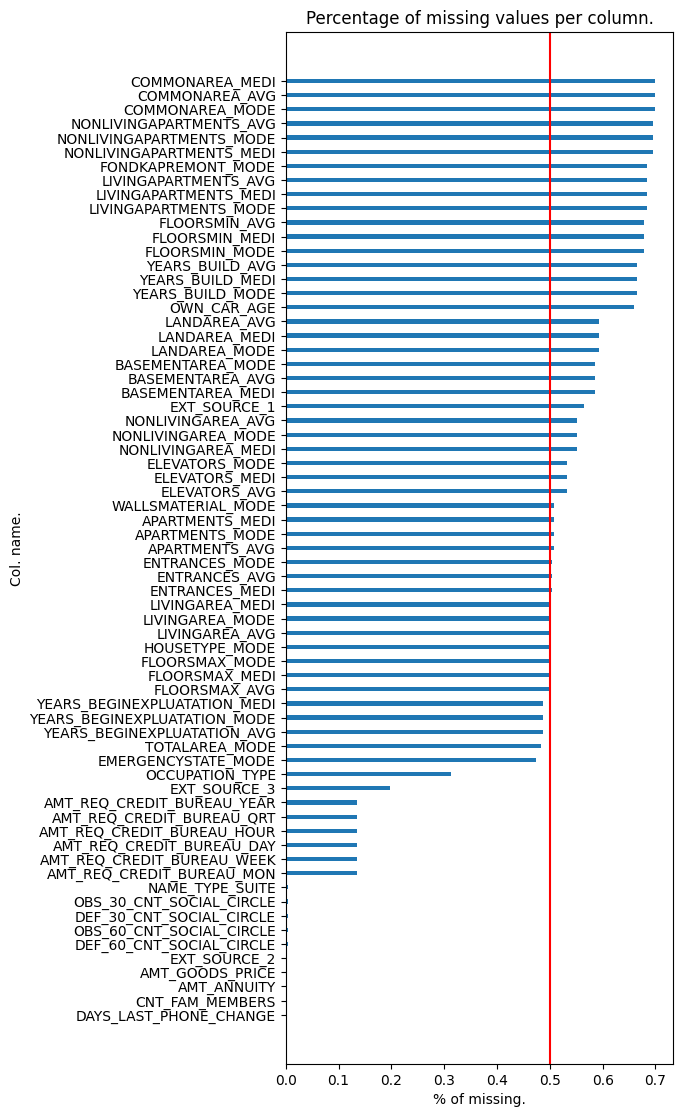

In [16]:
application = pd.read_csv(os.path.join(
    BASE_PATH, "application_train.csv"), index_col=id_curr)
na_status(application)
# More than 50% of the values of those columns are null, we create new columns and drop the old ones.
application["car_age_avail"] = application["OWN_CAR_AGE"].notna().map({
    True: 1, False: 0})
application["house_data_avail"] = application.loc[:,
                                                  "APARTMENTS_AVG":"EMERGENCYSTATE_MODE"].notna().sum(axis=1)
application.drop(
    application.loc[:, "APARTMENTS_AVG":"EMERGENCYSTATE_MODE"], inplace=True, axis=1)
application.drop("OWN_CAR_AGE", inplace=True, axis=1)

# Interesting data, we will keep the values and put 0 in to fill the gaps
application.fillna({"EXT_SOURCE_1": 0, "EXT_SOURCE_2": 0, "EXT_SOURCE_3": 0, "AMT_REQ_CREDIT_BUREAU_YEAR": 0,
                    "AMT_REQ_CREDIT_BUREAU_QRT": 0, "AMT_REQ_CREDIT_BUREAU_WEEK": 0,
                    "AMT_REQ_CREDIT_BUREAU_MON": 0, "AMT_REQ_CREDIT_BUREAU_DAY": 0,
                    "AMT_REQ_CREDIT_BUREAU_HOUR": 0}, inplace=True)


The next file worked on is `bureau.csv`. This file contains data regarding previous loans asked by the applicants. For each line of `application_train.csv` there are few lines in `bureau.csv`, therefore new columns containing sums and averages of each previous loans will be created by grouping on the basis of the id of the currently requested loan.  

Some of the new columns created are: the number of open credits, the number of closed ones, the ratio of open credits with respect to the total closed positions, the date of the oldest requested credit, the average time to close a credit, etc.

'Dataset has 1716428 rows and 16 columns.'

,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
SK_ID_CURR,,,,,,,,,,,,,,,,
215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
na_count,0,0,0,0,0,105553,633653,1124488,0,13,257669,591780,0,0,0,1226791


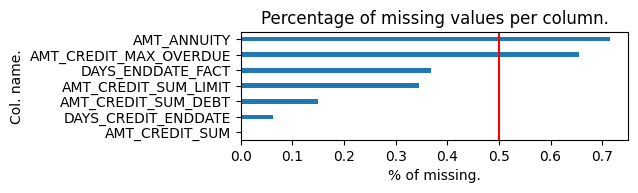

,n_open_credits,n_closed_credits,total_number_credits,open_close_ratio,percentage_active,most_recent_application,older_application,avg_time_remaining,avg_time_to_close,avg_credit_prolong,max_credit_prolong,min_credit_prolong,avg_credit_sum_requested,current_debts,credit_types
count,251815.000000,267925.000000,305811.000000,214118.000000,251815.000000,305811.000000,305811.000000,241346.000000,266172.000000,305811.000000,305811.000000,305811.000000,3.058090e+05,2.518150e+05,305811.000000
mean,2.504247,4.028265,5.612709,0.936630,0.498186,-490.942608,-1764.362845,2521.720272,-552.061102,0.007010,0.034894,0.001272,3.807398e+05,7.814595e+05,1.747560
std,1.670734,3.379669,4.430354,0.890093,0.266095,533.529324,859.260807,5553.248881,1763.815962,0.062334,0.223169,0.044239,8.792865e+05,1.757110e+06,0.643569
min,1.000000,1.000000,1.000000,0.025000,0.024390,-2922.000000,-2922.000000,-41874.000000,-41875.000000,0.000000,0.000000,0.000000,0.000000e+00,-6.978830e+06,1.000000
25%,1.000000,2.000000,2.000000,0.357143,0.285714,-623.000000,-2583.000000,277.000000,-1214.000000,0.000000,0.000000,0.000000,1.039616e+05,5.845500e+04,1.000000
50%,2.000000,3.000000,4.000000,0.666667,0.454545,-305.000000,-1822.000000,724.000000,-776.000000,0.000000,0.000000,0.000000,1.972972e+05,2.849632e+05,2.000000
75%,3.000000,5.000000,8.000000,1.000000,0.666667,-149.000000,-1045.000000,1436.000000,-331.666667,0.000000,0.000000,0.000000,3.978647e+05,8.386515e+05,2.000000
max,32.000000,108.000000,116.000000,15.000000,1.000000,0.000000,0.000000,31198.000000,31195.000000,6.000000,9.000000,6.000000,1.980723e+08,3.344983e+08,6.000000


In [17]:
bureau = pd.read_csv(os.path.join(BASE_PATH, 'bureau.csv'), index_col=id_curr)
na_status(bureau)
bureau_new = {}
# Historical data about previous credits in other credit institutes 
bureau_new["n_open_credits"] = bureau[bureau["CREDIT_ACTIVE"]
                                      == "Active"].groupby(id_curr)["CREDIT_ACTIVE"].count()
bureau_new["n_closed_credits"] = bureau[bureau["CREDIT_ACTIVE"]
                                        == "Closed"].groupby(id_curr)["CREDIT_ACTIVE"].count()
bureau_new["total_number_credits"] = bureau.groupby(
    id_curr)["CREDIT_ACTIVE"].count()
bureau_new["open_close_ratio"] = bureau_new["n_open_credits"] / \
    bureau_new["n_closed_credits"]
bureau_new["percentage_active"] = bureau_new["n_open_credits"] / \
    bureau_new["total_number_credits"]
# How old is the previous credit history and the last accepted loan
bureau_new["most_recent_application"] = bureau.groupby(id_curr)[
    "DAYS_CREDIT"].max()
bureau_new["older_application"] = bureau.groupby(id_curr)["DAYS_CREDIT"].min()
# How fast was this customer to close his loans and how meny time still needs on average for his open loans
bureau_new["avg_time_remaining"] = bureau[bureau["CREDIT_ACTIVE"]
                                          == "Active"].groupby(id_curr)["DAYS_CREDIT_ENDDATE"].mean()
bureau_new["avg_time_to_close"] = bureau[bureau["CREDIT_ACTIVE"]
                                         == "Closed"].groupby(id_curr)["DAYS_CREDIT_ENDDATE"].mean()
# How many prolongs he requested
bureau_new["avg_credit_prolong"] = bureau.groupby(
    id_curr)["CNT_CREDIT_PROLONG"].mean()
bureau_new["max_credit_prolong"] = bureau.groupby(
    id_curr)["CNT_CREDIT_PROLONG"].max()
bureau_new["min_credit_prolong"] = bureau.groupby(
    id_curr)["CNT_CREDIT_PROLONG"].min()
bureau_new["avg_credit_sum_requested"] = bureau.groupby(id_curr)[
    "AMT_CREDIT_SUM"].mean()
# How many money he still owes
bureau_new["current_debts"] = bureau[bureau["CREDIT_ACTIVE"]
                                     == "Active"].groupby(id_curr)["AMT_CREDIT_SUM_DEBT"].sum()
bureau_new["credit_types"] = bureau.groupby(id_curr)["CREDIT_TYPE"].nunique()
bureau_new = pd.DataFrame(bureau_new)
display(bureau_new.describe())


The file `previous_application.csv` is similar to `bureau.csv`, but contains data of previously requested credits at Home Credit.  
Also in this case an aggregation is required, otherwise a one-to-many merge would be performed. Few examples of the new columns created are: the number of credits rejected in the past, the number of approved credits, the average sum for loans accepted and reject and the average price of the goods accepted and rejected loans.  

In this case the sums granted and rejected during the last 3, 6, 12 and 24 months were calculated. This time binning is based on the idea that recent history has a more important impact on recent credit requests, therefore calculating a simple mean for all the previously requested loans would exclude important information.

At the end data about the latest accepted and rejected loans (amount of the annuity and credit, the number of passed days since the decision, if the credit was insured or not, etc.) was extracted.  

'Dataset has 1670214 rows and 36 columns.'

,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
SK_ID_PREV,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
na_count,0,0,372235,0,1,895844,385515,0,0,0,0,895844,1664263,1664263,0,0,0,0,0,820405,0,0,0,0,0,0,0,372230,0,346,673065,673065,673065,673065,673065,673065


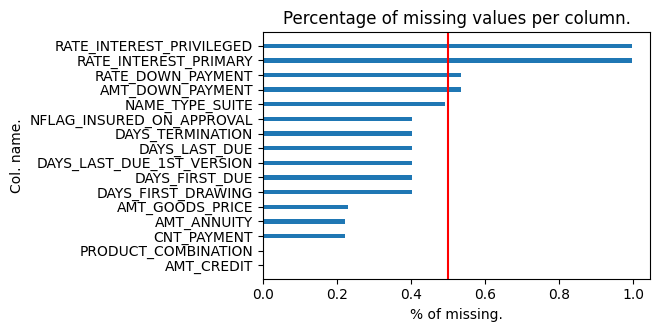

,n_rejections,n_approvals,rejections_approval_ratio,avg_sum_accepted,avg_sum_rejected,avg_goods_price_accepted,avg_goods_price_rejected,avg_sum_accepted_3m,avg_sum_rejected_3m,avg_sum_accepted_6m,avg_sum_rejected_6m,avg_sum_accepted_12m,avg_sum_rejected_12m,avg_sum_accepted_24m,avg_sum_rejected_24m,AMT_ANNUITY_L_REJECTION,AMT_APPLICATION_L_REJECTION,AMT_CREDIT_L_REJECTION,AMT_GOODS_PRICE_L_REJECTION,DAYS_DECISION_L_REJECTION,NFLAG_INSURED_ON_APPROVAL_L_REJECTION,AMT_ANNUITY_L_APPROVAL,AMT_APPLICATION_L_APPROVAL,AMT_CREDIT_L_APPROVAL,AMT_GOODS_PRICE_L_APPROVAL,DAYS_DECISION_L_APPROVAL,NFLAG_INSURED_ON_APPROVAL_L_APPROVAL,rejection_approval_time_distance,different_credit_types_requested
count,132694.000000,337698.000000,132240.000000,3.376980e+05,1.326940e+05,3.366210e+05,9.655000e+03,2.204800e+04,3.375000e+04,3.411300e+04,3.739200e+04,1.007840e+05,7.346500e+04,1.797430e+05,3.223300e+04,5913.000000,1.326940e+05,1.326940e+05,6.116000e+03,132694.000000,0.0,337693.000000,3.376980e+05,3.376980e+05,3.285680e+05,337698.000000,324425.000000,132240.000000,338152.000000
mean,2.383823,3.070143,0.819019,1.844319e+05,3.032154e+04,1.743019e+05,6.546207e+05,2.016933e+05,2.467938e+04,2.226042e+05,2.137604e+04,2.467739e+05,2.060317e+04,2.769526e+05,4.742920e+04,30769.231758,3.061222e+04,3.233833e+04,6.641691e+05,-263.818658,NaN,16860.586763,2.327701e+05,2.575224e+05,2.392382e+05,-604.966654,0.339653,157.784316,1.884147
std,2.030735,2.131516,0.832630,1.770702e+05,1.596378e+05,1.700909e+05,5.026799e+05,2.766681e+05,1.349311e+05,2.770807e+05,1.309816e+05,2.939824e+05,1.359260e+05,3.186492e+05,2.135368e+05,18732.695577,1.779394e+05,1.864780e+05,5.159499e+05,160.996621,NaN,15268.815018,3.004854e+05,3.261728e+05,3.020811e+05,561.990749,0.473592,412.928628,0.778190
min,1.000000,1.000000,0.041667,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1324.305000,0.000000e+00,0.000000e+00,0.000000e+00,-2912.000000,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,-2922.000000,0.000000,-2685.000000,1.000000
25%,1.000000,1.000000,0.333333,7.191788e+04,0.000000e+00,6.966072e+04,2.700000e+05,5.127264e+04,0.000000e+00,5.931450e+04,0.000000e+00,6.863625e+04,0.000000e+00,7.938900e+04,0.000000e+00,17400.510000,0.000000e+00,0.000000e+00,2.475000e+05,-358.000000,NaN,6808.635000,5.791500e+04,6.219900e+04,6.247800e+04,-736.000000,0.000000,-8.000000,1.000000
50%,2.000000,3.000000,0.500000,1.270395e+05,0.000000e+00,1.190846e+05,4.545000e+05,9.672975e+04,0.000000e+00,1.176590e+05,0.000000e+00,1.350000e+05,0.000000e+00,1.515870e+05,0.000000e+00,26827.695000,0.000000e+00,0.000000e+00,4.545000e+05,-258.000000,NaN,12019.140000,1.189386e+05,1.302705e+05,1.243350e+05,-438.000000,0.000000,0.000000,2.000000
75%,3.000000,4.000000,1.000000,2.368257e+05,0.000000e+00,2.189925e+05,9.000000e+05,2.122701e+05,0.000000e+00,2.605680e+05,0.000000e+00,2.876850e+05,0.000000e+00,3.485182e+05,0.000000e+00,40526.640000,0.000000e+00,0.000000e+00,9.000000e+05,-159.000000,NaN,22048.560000,2.700000e+05,2.953665e+05,2.700000e+05,-247.000000,1.000000,281.000000,3.000000
max,58.000000,27.000000,29.000000,4.050000e+06,3.524220e+06,4.050000e+06,3.825000e+06,2.517300e+06,2.943000e+06,3.420270e+06,2.700000e+06,2.660530e+06,3.600000e+06,4.050000e+06,3.150000e+06,210375.000000,4.237875e+06,3.524220e+06,4.237875e+06,-2.000000,NaN,300425.445000,4.050000e+06,4.050000e+06,4.050000e+06,-1.000000,1.000000,2895.000000,4.000000


In [18]:
previous_appl = pd.read_csv(os.path.join(
    BASE_PATH, 'previous_application.csv'), index_col=id_prev)
na_status(previous_appl)
previous_appl_new = {}
# Historical data of loans requested here.
previous_appl_new["n_rejections"] = previous_appl[previous_appl["NAME_CONTRACT_STATUS"]
                                                  == "Canceled"].groupby(id_curr)["NAME_CONTRACT_STATUS"].count()
previous_appl_new["n_approvals"] = previous_appl[previous_appl["NAME_CONTRACT_STATUS"]
                                                 == "Approved"].groupby(id_curr)["NAME_CONTRACT_STATUS"].count()
previous_appl_new["rejections_approval_ratio"] = previous_appl_new["n_rejections"] / \
    previous_appl_new["n_approvals"]
# Avg previously accepted credits, rejected, goods price
previous_appl_new["avg_sum_accepted"] = previous_appl[previous_appl["NAME_CONTRACT_STATUS"]
                                                      == "Approved"].groupby(id_curr)["AMT_CREDIT"].mean()
previous_appl_new["avg_sum_rejected"] = previous_appl[previous_appl["NAME_CONTRACT_STATUS"]
                                                      == "Canceled"].groupby(id_curr)["AMT_CREDIT"].mean()
previous_appl_new["avg_goods_price_accepted"] = previous_appl[previous_appl["NAME_CONTRACT_STATUS"]
                                                              == "Approved"].groupby(id_curr)["AMT_GOODS_PRICE"].mean()
previous_appl_new["avg_goods_price_rejected"] = previous_appl[previous_appl["NAME_CONTRACT_STATUS"]
                                                              == "Canceled"].groupby(id_curr)["AMT_GOODS_PRICE"].mean()
# Average sums granted and rejected during the last 3, 6, 12, 24 months
for i, j in [(0, 3), (3, 6), (6, 12), (12, 24)]:
    bool_mask_approved = (previous_appl["DAYS_DECISION"] >= -j*30) & (
        previous_appl["DAYS_DECISION"] <= -i*30) & (previous_appl["NAME_CONTRACT_STATUS"] == "Approved")
    bool_mask_rejected = (previous_appl["DAYS_DECISION"] >= -j*30) & (
        previous_appl["DAYS_DECISION"] <= -i*30) & (previous_appl["NAME_CONTRACT_STATUS"] == "Canceled")
    previous_appl_new["avg_sum_accepted_%im" % j] = previous_appl[bool_mask_approved].groupby(id_curr)[
        "AMT_CREDIT"].mean()
    previous_appl_new["avg_sum_rejected_%im" % j] = previous_appl[bool_mask_rejected].groupby(
        id_curr)["AMT_APPLICATION"].mean()
previous_appl_new = pd.DataFrame(previous_appl_new)
# Data from latest failed and approved application in this credit institute for the current application
id_latest_rejection = previous_appl[previous_appl["NAME_CONTRACT_STATUS"] == "Canceled"].groupby(id_curr)[
    "DAYS_DECISION"].idxmin()
id_latest_approval = previous_appl[previous_appl["NAME_CONTRACT_STATUS"] == "Approved"].groupby(id_curr)[
    "DAYS_DECISION"].idxmax()
historical_data = ["SK_ID_CURR", "NAME_CONTRACT_TYPE", "AMT_ANNUITY", "AMT_APPLICATION",
                   "AMT_CREDIT", "AMT_GOODS_PRICE", "DAYS_DECISION", "NFLAG_INSURED_ON_APPROVAL"]
latest_rejection_data = previous_appl.loc[id_latest_rejection, historical_data]
latest_approval_data = previous_appl.loc[id_latest_approval, historical_data]
previous_appl_new = previous_appl_new.merge(
    latest_rejection_data, on=id_curr, how="left")
previous_appl_new = previous_appl_new.merge(
    latest_approval_data, how="left", on=id_curr, suffixes=["_L_REJECTION", "_L_APPROVAL"])
previous_appl_new.set_index(id_curr, inplace=True)
# How meny time passed since latest rejection and approval
previous_appl_new["rejection_approval_time_distance"] = previous_appl_new["DAYS_DECISION_L_REJECTION"] - \
    previous_appl_new["DAYS_DECISION_L_APPROVAL"]
previous_appl_new["different_credit_types_requested"] = previous_appl.groupby(
    id_curr)["NAME_CONTRACT_TYPE"].nunique()
display(previous_appl_new.describe())


The `POS_CASH_balance.csv` file contains monthly balance snapshots about the loans that customers have taken during the past with Home Credit.  
Similarly to the previous files, this .csv contains one row for each month of each loan, therefore time has been discretized in intervals of 3, 6, 12 and 24 months. In this way it is possible to have a clear idea of the trend for each customer that is requesting a loan today.

The new columns are the average number of installments remaining for the loans, and the average number of days past due accumulated during the last months.

'Dataset has 10001358 rows and 7 columns.'

,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
SK_ID_PREV,,,,,,,
1803195,182943,-31,48.0,45.0,Active,0,0
1715348,367990,-33,36.0,35.0,Active,0,0
1784872,397406,-32,12.0,9.0,Active,0,0
1903291,269225,-35,48.0,42.0,Active,0,0
2341044,334279,-35,36.0,35.0,Active,0,0


,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
na_count,0,0,26071,26087,0,0,0


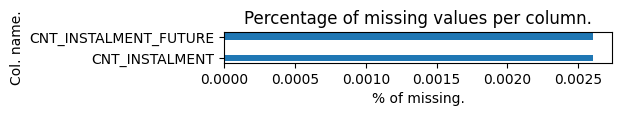

,avg_installments_remaining_future_3m,avg_dpd_def_3m,avg_dpd_3m,avg_installments_remaining_future_6m,avg_dpd_def_6m,avg_dpd_6m,avg_installments_remaining_future_12m,avg_dpd_def_12m,avg_dpd_12m,avg_installments_remaining_future_24m,avg_dpd_def_24m,avg_dpd_24m
count,160921.000000,161387.000000,161387.000000,187072.000000,187488.000000,187488.000000,226514.000000,226984.000000,226984.000000,242251.000000,242872.000000,242872.000000
mean,11.423297,0.524973,8.896341,11.539378,0.429426,8.454177,11.840916,0.341418,6.196502,12.438949,0.337241,5.450059
std,12.201258,32.266646,141.655923,11.859534,29.144867,134.972852,11.016904,24.076649,110.886260,10.301457,23.715091,99.220421
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,3.500000,0.000000,0.000000,4.333333,0.000000,0.000000,5.437500,0.000000,0.000000
50%,7.333333,0.000000,0.000000,7.500000,0.000000,0.000000,8.923077,0.000000,0.000000,9.318182,0.000000,0.000000
75%,15.000000,0.000000,0.000000,15.500000,0.000000,0.000000,16.000000,0.000000,0.000000,17.000000,0.000000,0.000000
max,81.000000,3246.666667,4201.000000,71.500000,3170.250000,4125.750000,71.500000,2824.428571,3988.000000,60.000000,2855.307692,3532.230769


In [19]:
pos_cash_balance = pd.read_csv(os.path.join(
    BASE_PATH, 'POS_CASH_balance.csv'), index_col=id_prev)
na_status(pos_cash_balance)
pos_new = {}
# Information about loans: what was the trend during the last months.
for i, j in [(0, 3), (3, 6), (6, 12), (12, 24)]:
    bool_mask = (pos_cash_balance["MONTHS_BALANCE"]
                 >= -j) & (pos_cash_balance["MONTHS_BALANCE"] <= -i)
    pos_new["avg_installments_remaining_future_%im" %
            j] = pos_cash_balance[bool_mask].groupby(id_curr)["CNT_INSTALMENT_FUTURE"].mean()
    pos_new["avg_dpd_def_%im" % j] = pos_cash_balance[bool_mask].groupby(id_curr)[
        "SK_DPD_DEF"].mean()
    pos_new["avg_dpd_%im" % j] = pos_cash_balance[bool_mask].groupby(id_curr)[
        "SK_DPD"].mean()
pos_new = pd.DataFrame(pos_new)
display(pos_new.describe())


`installments_payments.csv` cointains data regarding the monthly repayments of the loans previosuly insured by Home Credit.  

Data has been discretized in 3, 6, 12, 24 months to show the trend of: the average delay in payment, the average "deviation" of payment (i.e. what was paid vs what the user should have paid) and the average amount paid.  

'Dataset has 13605401 rows and 7 columns.'

,SK_ID_PREV,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
SK_ID_CURR,,,,,,,
161674,1054186,1.0,6,-1180.0,-1187.0,6948.360,6948.360
151639,1330831,0.0,34,-2156.0,-2156.0,1716.525,1716.525
193053,2085231,2.0,1,-63.0,-63.0,25425.000,25425.000
199697,2452527,1.0,3,-2418.0,-2426.0,24350.130,24350.130
167756,2714724,1.0,2,-1383.0,-1366.0,2165.040,2160.585


,SK_ID_PREV,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
na_count,0,0,0,0,2905,0,2905


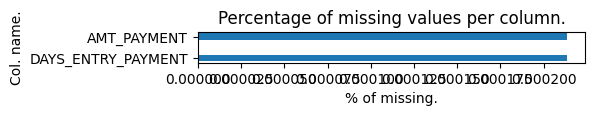

,avg_delay_payment_3m,avg_deviation_payment_3m,avg_payment_3m,avg_delay_payment_6m,avg_deviation_payment_6m,avg_payment_6m,avg_delay_payment_12m,avg_deviation_payment_12m,avg_payment_12m,avg_delay_payment_24m,avg_deviation_payment_24m,avg_payment_24m
count,185827.000000,185827.000000,1.858270e+05,201865.000000,2.018650e+05,2.018650e+05,231165.000000,231165.000000,2.311650e+05,238844.000000,238844.000000,2.388440e+05
mean,-9.830117,547.821010,2.474159e+04,-10.442809,1.047161e+03,2.746669e+04,-11.077282,1321.618369,3.097560e+04,-11.381626,1134.522923,2.867344e+04
std,13.140453,10392.576423,6.809788e+04,12.682244,1.337740e+04,6.999814e+04,11.585244,13546.586246,7.215254e+04,11.508299,11791.128920,5.928885e+04
min,-550.000000,-65931.176250,4.500000e-02,-496.000000,-1.933273e+05,4.500000e-02,-392.000000,-182905.031250,4.500000e-02,-917.000000,-169033.935000,4.500000e-02
25%,-12.777778,0.000000,6.435427e+03,-13.666667,0.000000e+00,6.872625e+03,-14.444444,0.000000,7.875000e+03,-15.000000,0.000000,8.344814e+03
50%,-6.666667,0.000000,1.198683e+04,-7.600000,0.000000e+00,1.272722e+04,-8.600000,0.000000,1.420236e+04,-9.090909,0.000000,1.468417e+04
75%,-2.333333,0.000000,2.232303e+04,-3.111111,0.000000e+00,2.414682e+04,-4.240000,0.000000,2.789129e+04,-4.875000,0.000000,2.833051e+04
max,68.000000,547500.000000,2.784334e+06,127.666667,1.043332e+06,2.478657e+06,263.666667,650250.000000,2.912742e+06,605.000000,600000.000000,2.305956e+06


In [20]:
installments_payment = pd.read_csv(os.path.join(
    BASE_PATH, 'installments_payments.csv'), index_col=id_curr)
na_status(installments_payment)
inst_pay_new = {}
#Trend of payments during the last months.
for i, j in [(0, 3), (3, 6), (6, 12), (12, 24)]:
    bool_mask = (installments_payment["DAYS_INSTALMENT"] >= -
                 j*30) & (installments_payment["DAYS_INSTALMENT"] <= -i*30)
    inst_pay_new["avg_delay_payment_%im" % j] = (
        installments_payment[bool_mask]["DAYS_ENTRY_PAYMENT"] - installments_payment[bool_mask]["DAYS_INSTALMENT"]).groupby(id_curr).mean()
    inst_pay_new["avg_deviation_payment_%im" % j] = (
        installments_payment[bool_mask]["AMT_PAYMENT"] - installments_payment[bool_mask]["AMT_INSTALMENT"]).groupby(id_curr).mean()
    inst_pay_new["avg_payment_%im" %
                 j] = installments_payment[bool_mask]["AMT_PAYMENT"].groupby(id_curr).mean()
inst_pay_new = pd.DataFrame(inst_pay_new)
display(inst_pay_new.describe())


The `credit_card_balance.csv` contains monthly snapshots of credit card balances for people with an account in Home Credit.  

A time discretization in 3, 6, 12, 24 month was done, therefore the trend can be seen in: the amount of credit a credit card is allowed to receive, the amount of drawings performed, the repayments made, the count of installments the account is accumulating and the days past due in the payments during the last months.

'Dataset has 3840312 rows and 22 columns.'

,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
SK_ID_PREV,,,,,,,,,,,,,,,,,,,,,,
2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
na_count,0,0,0,0,749816,0,749816,749816,305236,767988,0,0,0,0,749816,0,749816,749816,305236,0,0,0


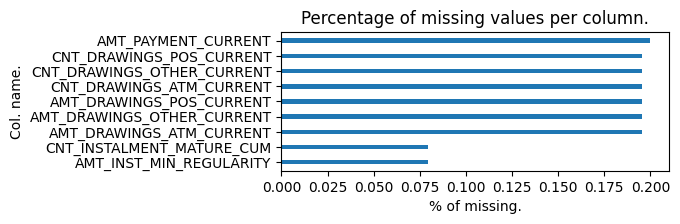

,amt_credit_limit_3m,amt_drawings_current_3m,drawing_limit_ratio_3m,amt_payment_total_3m,amt_receivable_total_3m,payed_recivable_ratio,cnt_drawings_current_3m,cnt_instalment_current_3m,sk_dpd_3m,sk_dpd_def_3m,amt_credit_limit_6m,amt_drawings_current_6m,drawing_limit_ratio_6m,amt_payment_total_6m,amt_receivable_total_6m,cnt_drawings_current_6m,cnt_instalment_current_6m,sk_dpd_6m,sk_dpd_def_6m,amt_credit_limit_12m,amt_drawings_current_12m,drawing_limit_ratio_12m,amt_payment_total_12m,amt_receivable_total_12m,cnt_drawings_current_12m,cnt_instalment_current_12m,sk_dpd_12m,sk_dpd_def_12m,amt_credit_limit_24m,amt_drawings_current_24m,drawing_limit_ratio_24m,amt_payment_total_24m,amt_receivable_total_24m,cnt_drawings_current_24m,cnt_instalment_current_24m,sk_dpd_24m,sk_dpd_def_24m
count,1.006770e+05,1.006770e+05,1.006770e+05,1.006770e+05,1.006770e+05,7.451900e+04,100677.000000,100677.000000,100677.000000,100677.000000,1.025490e+05,1.025490e+05,102549.000000,1.025490e+05,1.025490e+05,102549.00000,102549.000000,102549.000000,102549.000000,9.801000e+04,9.801000e+04,9.801000e+04,9.801000e+04,9.801000e+04,98010.000000,98010.000000,98010.000000,98010.000000,7.451900e+04,7.451900e+04,7.451900e+04,7.451900e+04,7.451900e+04,74519.000000,74519.000000,74519.000000,74519.000000
mean,1.761036e+05,8.880127e+03,1.218839e+02,2.319005e+04,2.050104e+05,2.181700e+03,3.686592,42.652125,8.107496,0.229430,1.794286e+05,1.044659e+04,252.770729,3.671810e+04,2.689278e+05,5.61359,60.006036,9.483999,0.273844,1.869302e+05,1.403268e+04,3.995695e+02,6.149008e+04,3.907951e+05,8.095735,100.374482,9.604107,0.260622,2.192844e+05,1.379269e+04,2.742934e+02,9.209887e+04,5.943767e+05,8.687422,211.295817,11.586228,0.307130
std,2.038209e+05,3.102266e+04,6.492138e+03,7.986290e+04,4.012430e+05,2.599572e+04,12.297231,60.673230,110.028658,21.517752,2.059046e+05,3.044100e+04,8242.468730,1.087783e+05,5.361166e+05,17.27311,85.309549,117.733656,23.791691,2.122658e+05,3.440939e+04,9.876096e+03,1.635869e+05,8.278283e+05,22.784923,149.962961,113.572635,22.895393,2.160358e+05,3.555952e+04,8.068779e+03,2.189194e+05,1.227542e+06,25.007547,288.292044,112.398028,23.478576
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,3.600000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,4.500000e+04,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.00000,0.000000,0.000000,0.000000,4.500000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,6.576923e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
50%,1.350000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,18.000000,0.000000,0.000000,1.237500e+05,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.00000,22.000000,0.000000,0.000000,1.125000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,21.000000,0.000000,0.000000,1.488462e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,55.000000,0.000000,0.000000
75%,2.250000e+05,2.411505e+03,1.388884e-02,2.025000e+04,2.719199e+05,1.486009e-01,1.000000,57.000000,0.000000,0.000000,2.306250e+05,5.270827e+03,0.024999,3.150000e+04,3.308125e+05,3.00000,86.000000,0.000000,0.000000,2.700000e+05,1.356532e+04,7.469862e-02,5.400000e+04,3.553882e+05,6.000000,147.000000,0.000000,0.000000,3.115385e+05,1.332346e+04,5.738065e-02,9.892350e+04,5.505839e+05,7.000000,338.000000,0.000000,0.000000
max,1.350000e+06,1.917547e+06,1.125000e+06,5.353137e+06,3.417260e+06,2.120889e+06,395.000000,357.000000,2785.000000,2785.000000,1.350000e+06,1.322823e+06,900000.000000,3.962477e+0

In [21]:
credit_card_bal = pd.read_csv(os.path.join(
    BASE_PATH, 'credit_card_balance.csv'), index_col=id_prev)
na_status(credit_card_bal)
cc_bal_new = {}
#Credit card balance trend
for i, j in [(0, 3), (3, 6), (6, 12), (12, 24)]:
    bool_mask = (credit_card_bal["MONTHS_BALANCE"] >= -
                 j) & (credit_card_bal["MONTHS_BALANCE"] <= -i)
    # Credit limit and amount of drawings
    cc_bal_new["amt_credit_limit_%im" % j] = credit_card_bal[bool_mask].groupby(
        id_curr)["AMT_CREDIT_LIMIT_ACTUAL"].mean()
    cc_bal_new["amt_drawings_current_%im" % j] = credit_card_bal[bool_mask].groupby(
        id_curr)["AMT_DRAWINGS_CURRENT"].mean()
    cc_bal_new["drawing_limit_ratio_%im" % j] = cc_bal_new["amt_drawings_current_%im" %
                                                           j] / (cc_bal_new["amt_credit_limit_%im" % j] + 1)
    # Amount of repaymens done and to be done
    cc_bal_new["amt_payment_total_%im" % j] = credit_card_bal[bool_mask].groupby(
        id_curr)["AMT_PAYMENT_TOTAL_CURRENT"].sum()
    cc_bal_new["amt_receivable_total_%im" % j] = credit_card_bal[bool_mask].groupby(
        id_curr)["AMT_TOTAL_RECEIVABLE"].sum()
    cc_bal_new["payed_recivable_ratio"] = cc_bal_new["amt_payment_total_%im" %
                                                     j]/(cc_bal_new["amt_receivable_total_%im" % j] + 1)
    # Count of installment to be paid and drawings data
    cc_bal_new["cnt_drawings_current_%im" % j] = credit_card_bal[bool_mask].groupby(
        id_curr)["CNT_DRAWINGS_CURRENT"].sum()
    cc_bal_new["cnt_instalment_current_%im" % j] = credit_card_bal[bool_mask].groupby(
        id_curr)["CNT_INSTALMENT_MATURE_CUM"].sum()
    cc_bal_new["sk_dpd_%im" % j] = credit_card_bal[bool_mask].groupby(id_curr)[
        "SK_DPD"].mean()
    cc_bal_new["sk_dpd_def_%im" % j] = credit_card_bal[bool_mask].groupby(id_curr)[
        "SK_DPD_DEF"].mean()
cc_bal_new = pd.DataFrame(cc_bal_new)
display(cc_bal_new.describe())


All the new dataframes were merged into a unique dataframe containing all the information about the currently requested loan and the past credit history of the customer.

In [22]:
# Final merge of new dfs
application = application.merge(bureau_new, how="left", on=id_curr)
application = application.merge(previous_appl_new, how="left", on=id_curr)
application = application.merge(pos_new, how="left", on=id_curr)
application = application.merge(inst_pay_new, how="left", on=id_curr)
application = application.merge(cc_bal_new, how="left", on=id_curr)


## Data Preparation - Feature engeneering
In order to get a better performance, new columns have been created from the already existing ones.  

- The Loan to Value was calculated by dividing the amount of credit requested by the price of the goods being purchased and it provides knowledge on the financed amount.  

- The Debt to Income was calculated by dividing the annuity payment by the borrower's total income. It provides knowledge on the portion of the borrower's income that is being used to pay debts. Good_ind indicates the income of the applicant divided by the number of family members. It provides knowledge about the income available for each member of the family.  

- Good-empl was obtained by dividing the income of the applicant by the number of days they have worked in their current job. It provides knowledge on the person's financial stability and on how long they have been employed.  

- Downpayment was calculated by obtaining the difference between the price of the goods being purchased and the amount of credit requested. It proved knowledge on how much the borrower is putting down as a deposit.  

- Age was calculated by simply dividing the number of days since the borrower's birth by 365.  

- NEW_PRICE_RATIO was calculated by dividing the credit requested in the previous application by the final credit amount approved for the previous application.  

- NEW_AMT_CREDIT_RATIO_L_APPROVAL was obtained by dividing the amount of credit requested in the previous application by the price of the actual goods being with that amount.  

- NEW_PRICE_RATIO_REJ was calculated by dividing the credit requested in the previous application by the final credit amount (but this time rejected) for the previous application.  

- NEW_AMT_CREDIT_RATIO_L_REJ was obtained again by dividing the amount of credit requested in the previous application by the price of the goods.

In [23]:
# Features enginereed
application["ltv"] = application["AMT_CREDIT"]/application["AMT_GOODS_PRICE"]
application["dti"] = application["AMT_ANNUITY"]/application["AMT_INCOME_TOTAL"]
application["good_ind"] = application["AMT_INCOME_TOTAL"] / \
    application["CNT_FAM_MEMBERS"]
application["good_empl"] = application["AMT_INCOME_TOTAL"] / \
    (application["DAYS_EMPLOYED"]-1)
application["downpayment"] = application["AMT_GOODS_PRICE"] - \
    application["AMT_CREDIT"]
application["age"] = application["DAYS_BIRTH"]/365

# amount of loan applied for / price of the product to buy for approved
application['NEW_PRICE_RATIO'] = application['AMT_APPLICATION_L_APPROVAL'] / \
    application['AMT_GOODS_PRICE_L_APPROVAL']

# Credit requested in the previous application / final credit amount of the previous application for approved
application["NEW_AMT_CREDIT_RATIO_L_APPROVAL"] = application["AMT_APPLICATION_L_APPROVAL"] / \
    application["AMT_CREDIT_L_APPROVAL"]


# amount of loan applied for / price of the product to buy for rejected
application['NEW_PRICE_RATIO_REJ'] = application['AMT_APPLICATION_L_REJECTION'] / \
    application['AMT_GOODS_PRICE_L_REJECTION']

# Credit requested in the previous application / final credit amount of the previous application for approved
application["NEW_AMT_CREDIT_RATIO_L_REJ"] = application["AMT_APPLICATION_L_REJECTION"] / \
    application["AMT_CREDIT_L_REJECTION"]


## Data preparation - Dimensionality reduction and scaling
Considering that the large majority of the models used support only numerical data, One-hot encoding was performed by using `get_dummies`. The `drop_first` parameter was set to True to avoid multicollinearity between dummy variables.  

Fillna was used to fill the missing values with `-1` as a placeholder, other techniques (e.g. most frequent value, knn) were tried, but the gain in term of final performances was not significative.  

In [24]:
# Onehot encoding
application = pd.get_dummies(application, drop_first=True)
# Fillnas with most frequent for the others
application.fillna(-1, inplace=True)
display("Dataset has %i rows and %i columns." % application.shape)


'Dataset has 307511 rows and 295 columns.'

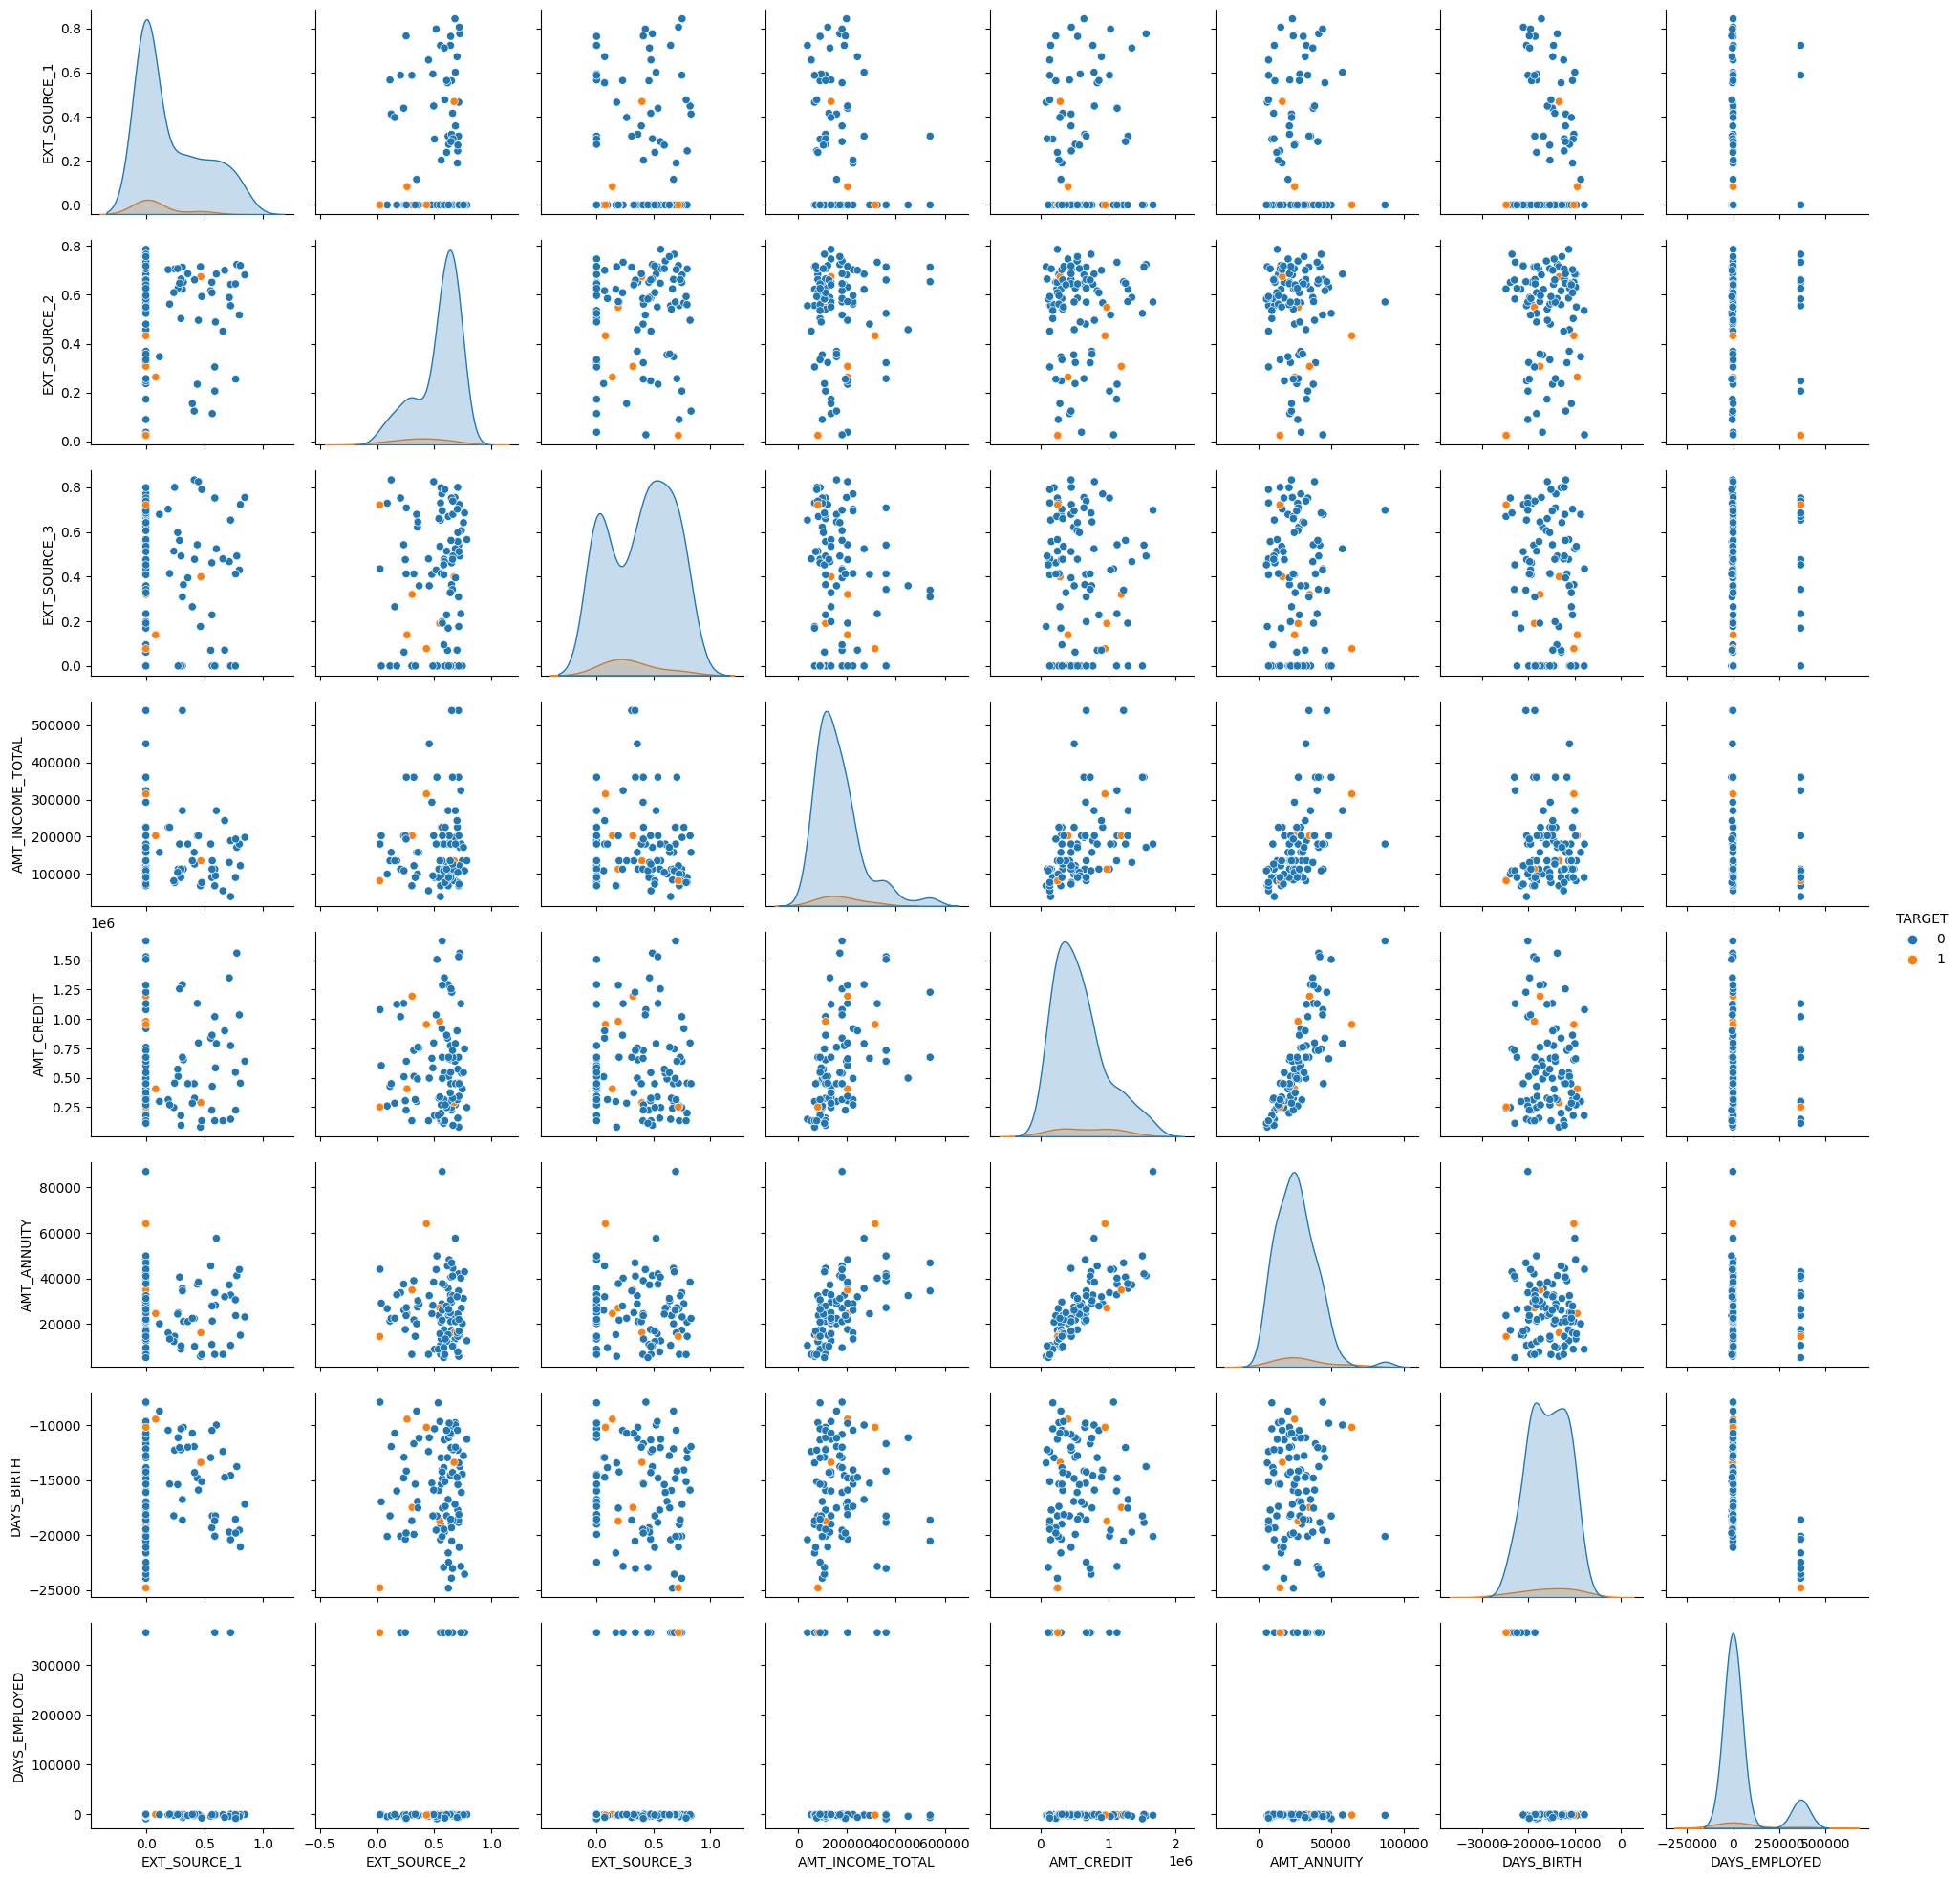

In [25]:
#pairplot of application with some chosen columns
columns = ['TARGET',"EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3","AMT_INCOME_TOTAL","AMT_CREDIT","AMT_ANNUITY", "DAYS_BIRTH","DAYS_EMPLOYED"]
application_plot = pd.DataFrame(application.loc[application.index[:100],columns])
sns.pairplot(application_plot,hue="TARGET")

In [26]:
# Modify test size to reduce or enlarge the size of the dataset to be used
test_size = application.shape[0]
X = application.iloc[:test_size, 1:]
y = application.iloc[:test_size, 0]
y = y.astype("int")


The most important features were selected by using the `f_regression`. `SelectPercentile` was used to select the top 30% of the features from the input dataset X, which consisted of a matrix of feature values and their corresponding target vector y. `fit_transform` was then used to transform X into a new dataset that only contains again the top 30% of the original features. 
From what can be seen from the plot blow, the results of the F-tests show that there is no single variable able to predict if a person will not give back the loan or not.

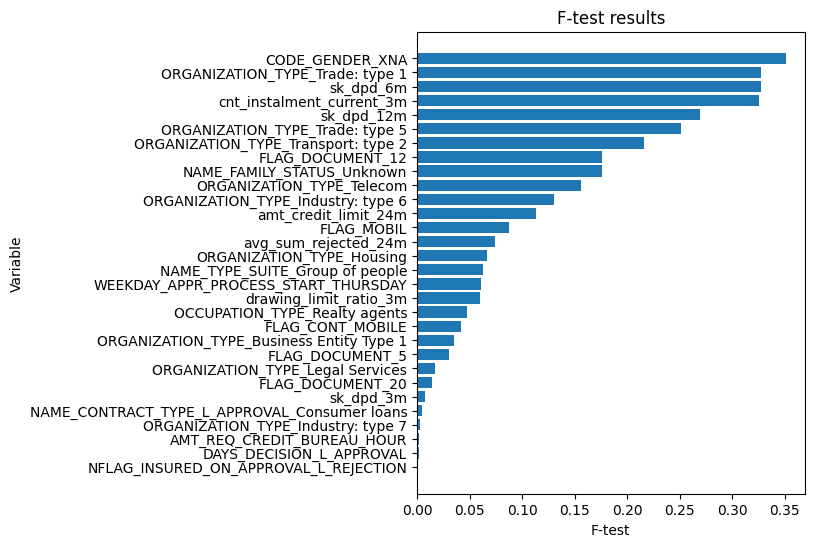

In [27]:
# Calculates the cross correlation for each predictor and y and returns the f-test and the corresponding p-value
F, pval = f_regression(X, y)

# associate the varname to his f-test
fvals_df = pd.DataFrame({'Variable': X.columns,
                         'F-test': F})

# the pvalue that are little are more significative, plot only the first 30 vars
fvals_df = fvals_df.sort_values(by='F-test',ascending=True).iloc[:30,:]

plt.figure(figsize=(5, fvals_df.shape[0]*0.2))
plt.barh(fvals_df['Variable'], fvals_df['F-test'])
plt.xlabel('F-test')
plt.ylabel('Variable')
plt.title('F-test results')
plt.show()

The data was scaled in order to perform the PCA and to further improve the performance of the classifiers. StandardScaler from the sklearn library was used to perform this task, but also other scaling techniques like Normalization and MinMaxScaling were tried. `fit_transform` was then used to scale the data.

In [28]:
# Data scaling
# Normalizer, MinMaxScaler
transformer = StandardScaler()
X = transformer.fit_transform(X)

# Feature selection
X = SelectPercentile(f_regression, percentile=30).fit_transform(X, y) 


To further reduce the dimensionality, a Principal Component Analysis was also performed by using `pca.fit_transform`. The number of principal components was set to keep just the 80% of the total variance. The plot shows how drastically the explained variance decreases by each principal component.  

The reason why PCA was performed after the first round of feature selection with `f_regression` derives from the fact that few of the choosen columns may be correlated, therefore, by performing the Principal Component Analysis, the new created columns are linear combinations of the original data and with 0 correlation between them.

In [29]:
# Dimensionality reduction
n_components = .8
pca = PCA(n_components)
X = pca.fit_transform(X, y)


As shown by the plot, the two classes are not easily linearly separable by just using the first two principal components. 

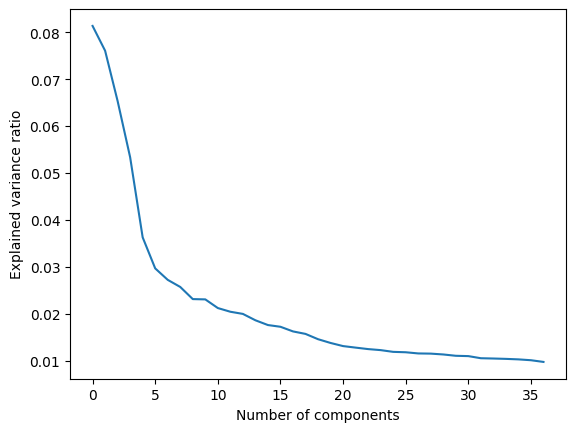

Dataset dimensionality after PCA (307511, 37)


In [30]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel("Number of components")
plt.ylabel("Explained variance ratio")
plt.show()
print("Dataset dimensionality after PCA", X.shape)

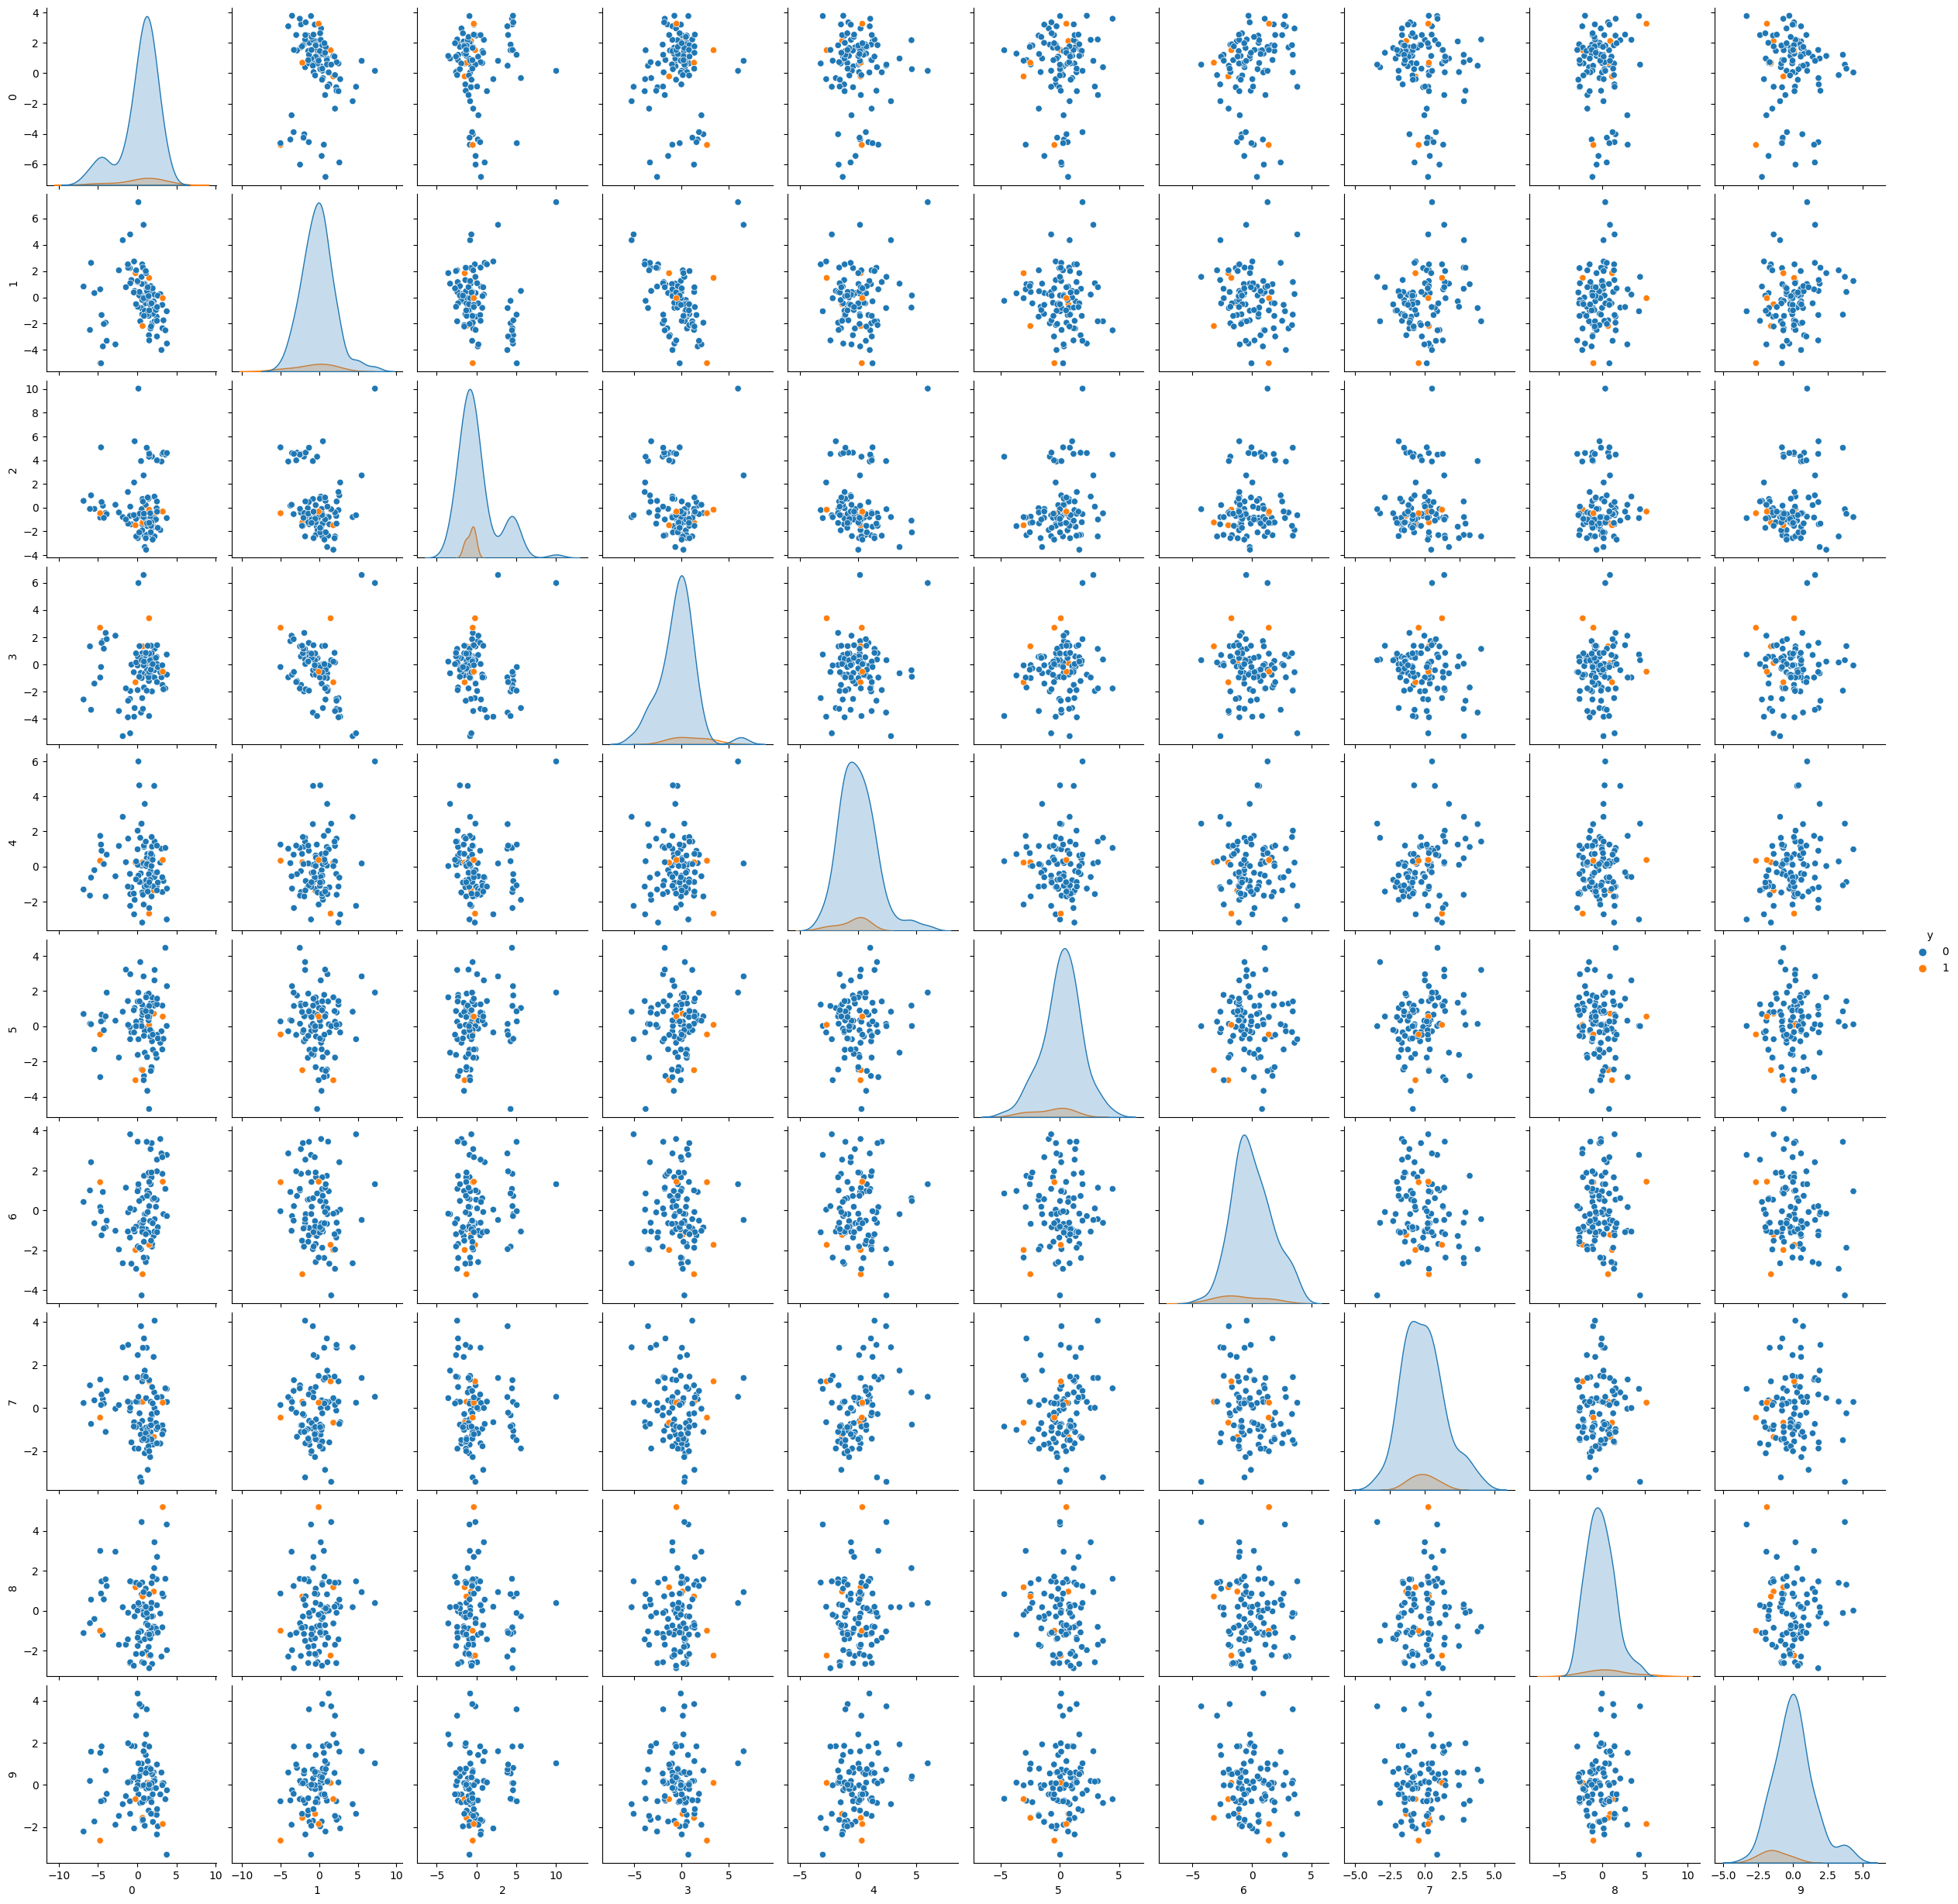

In [31]:
pca_plot = pd.DataFrame(X[:100,:10])
pca_plot["y"]= y.reset_index(drop=True)
#We plot just 100 rows and few columns to speed up the process
sns.pairplot(pca_plot, hue="y")

## Split data and rebalancing

Using `train_test_split` from the sklearn library, the dataset was split in four. The test set was set to 30% of the total dataset.  
`stratify` was used for doing stratified sampling, meaning that the proportions of classes in input and output variables remain the same in both the training and testing sets.

In [32]:
# Split data
X_train, x_test, Y_train, y_test = train_test_split(
    X, y, test_size=.3, stratify=y)
print(X_train.shape, x_test.shape, Y_train.shape, y_test.shape)


(215257, 37) (92254, 37) (215257,) (92254,)


A rebalancing of the training set is needed to train the models, otherwise the classifiers would learn only to recognize the majority class.
`RandomUnderSampler`, `RandomOversampler`, `SMOTE`, and `BorderlineSMOTE` were used to rebalance the training set by either undersampling the majority class (RandomUnderSampler), oversampling the minority class (RandomOversampler), or generating synthetic samples based on the existing minority class samples (SMOTE and BorderlineSMOTE).
In the end, `RandomUnderSampler` was the utilized one because was the method that has garanteed the minor overfitting.

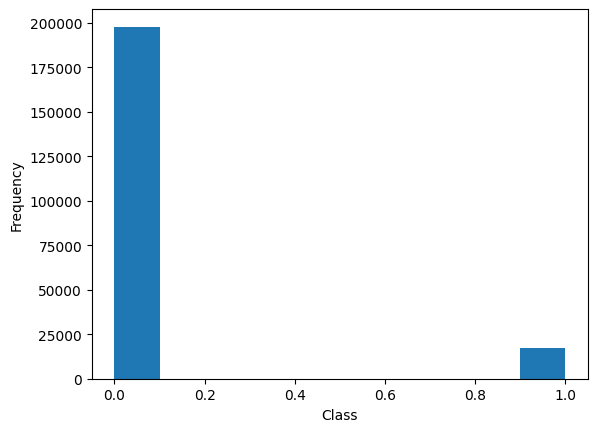

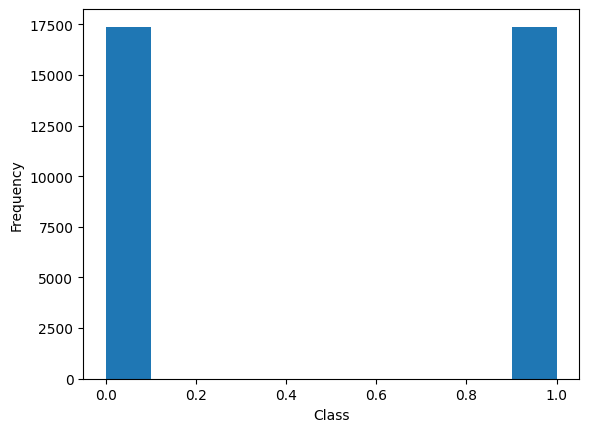

In [33]:
# Dataset balancing
plt.hist(Y_train)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()
# RandomUndersampler() RandomOversampler() SMOTE() BorderlineSMOTE()
balancer = RandomUnderSampler() 
X_train, Y_train = balancer.fit_resample(X_train, Y_train)
plt.hist(Y_train)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()


## Training phase
The training code defines a dictionary named models that contains five different machine learning models, including Decision Tree, Random Forest, Naive Bayes, Support Vector Machine, and Multi-Layer Perceptron. Each model has a set of hyperparameters that were tuned to improve its performance. The code then created an empty dictionary called optimized, which will stored the best estimator for each model.

The code uses the `RandomizedSearchCV` function from the scikit-learn library to tune the hyperparameters of each model. This function performs a randomized search over the hyperparameters space defined in the params dictionary for each model. The function selects the hyperparameters that maximize the F1 score, which is a metric that balances precision and recall. The best estimator for each model is then added to the `optimized` dictionary.

Finally, the code prints the F1 score and the best hyperparameters for each model that is enabled in the models dictionary. If a model is not enabled, the code skips it. This is useful for testing purposes and if one wants to see the performances of a specific model skipping the training phase all the others.

After tuning all the models, a `VotingClassifier` that combines all the optimized models was created. The `VotingClassifier` predicts the class with the highest number of votes from the individual models. The `VotingClassifier` is trained on the training data (X_train and Y_train) and added to the optimized dictionary.

In [34]:
models = {
    "dt": {"name": "Decision Tree",
           "enabled": 1,
           "estimator": DecisionTreeClassifier(),
           "params": {"criterion": ["gini", "entropy", "log_loss"],
                      "max_depth": list(range(1, 30)),
                      "min_samples_split": list(range(2, 20)),
                      "min_samples_leaf": list(range(1, 30))
                      }
           },
    "rf": {"name": "Random Forest",
           "enabled": 1,
           "estimator": RandomForestClassifier(),
           "params": {"n_estimators": list(range(100, 500)),
                      "criterion": ["gini", "entropy", "log_loss"],
                      "max_depth": list(range(1, 30)),
                      "min_samples_split": list(range(2, 20)),
                      "min_samples_leaf": list(range(1, 30))
                      }
           },
    "nb": {"name": "Naive Bayes",
           "enabled": 1,
           "estimator": GaussianNB(),
           "params": {"var_smoothing": np.linspace(1e-11, 1)}
           },
    "svm": {"name": "Support Vector Machine",
            "enabled": 1,
            "estimator": SVC(),
            "params": {"C": np.linspace(1, 100),
                       "gamma": np.linspace(1e-3, 1e-4),
                       "kernel": ["poly", "rbf", "sigmoid"]
                       }
            },
    "mlp": {"name": "Multi Layer Perceptron",
            "enabled": 1,
            "estimator": MLPClassifier(),
            "params": {"hidden_layer_sizes": np.arange(4, 100),
                       "activation": ["tanh", "relu", "logistic"],
                       "solver": ["sgd", "adam", "lbfgs"],
                       "alpha": np.linspace(1e-4, 1),  # l2 regularization
                       "batch_size": np.arange(8, 512, 2),
                       "learning_rate_init": np.linspace(1e-3, 1),
                       "learning_rate": ["constant", "invscaling", "adaptive"],
                       "power_t": np.linspace(5e-3, 5e-1),
                       "max_iter": np.arange(100, 1000),
                       "verbose": [False],
                       "momentum": np.linspace(1e-1, 1),
                       "early_stopping": [False, True],
                       }
            }
}
optimized = {}
for key, model in models.items():
    if model["enabled"]:
        t0 = time.time()
        log_level = 0  # Set 3 for logging purposes
        jobs = os.cpu_count() - 1
        optimizer = RandomizedSearchCV(model["estimator"], model["params"],
                                       scoring="f1_macro", n_jobs=jobs, n_iter=10, cv=5, refit=True, verbose=log_level)
        trained_model = optimizer.fit(X_train, Y_train)
        optimized[model["name"]] = trained_model.best_estimator_
        print("Training %s, " % model["name"] + "elapsed time: %f, " %
              (time.time() - t0) + "f1 score: %f" % trained_model.best_score_)
        print(trained_model.best_params_)
    else:
        print("Skipping", model["name"], "because is not enabled.")
optimized["Voting Classifier"] = VotingClassifier(
    list(optimized.items())).fit(X_train, Y_train)


Training Decision Tree, elapsed time: 11.593517, f1 score: 0.615416
{'min_samples_split': 13, 'min_samples_leaf': 18, 'max_depth': 8, 'criterion': 'entropy'}
Training Random Forest, elapsed time: 487.190710, f1 score: 0.661674
{'n_estimators': 463, 'min_samples_split': 12, 'min_samples_leaf': 19, 'max_depth': 19, 'criterion': 'entropy'}
Training Naive Bayes, elapsed time: 0.556476, f1 score: 0.542128
{'var_smoothing': 1e-11}
Training Support Vector Machine, elapsed time: 491.140179, f1 score: 0.671871
{'kernel': 'rbf', 'gamma': 0.0005959183673469388, 'C': 27.265306122448976}


/Users/norwegiangoat/git/ml_project_BBS/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/norwegiangoat/git/ml_project_BBS/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/norwegiangoat/git/ml_project_BBS/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perce

Training Multi Layer Perceptron, elapsed time: 84.535954, f1 score: 0.669838
{'verbose': False, 'solver': 'sgd', 'power_t': 0.1666326530612245, 'momentum': 0.8163265306122449, 'max_iter': 837, 'learning_rate_init': 0.8165102040816327, 'learning_rate': 'adaptive', 'hidden_layer_sizes': 57, 'early_stopping': False, 'batch_size': 400, 'alpha': 0.14294285714285712, 'activation': 'logistic'}


## Evaluation phase
The next step was calculating precision, recall and the F1 score using the macro average score for each class. This approach calculates the non weighted average of the metrics across all classes, in this way the scores for each class have an equal weigth regardless of the performance of the classifier on a specific class.

If the micro-average method was to be used, it would have "globally" computed the metrics by summing up the true positives, false positives, and false negatives across all classes. This method gives equal weight to each individual prediction, regardless of the class it belongs to, which can cause the metrics to be overly influenced by the performance of the class with the best scores.

[Macro Metrics]
Decision Tree Precision: 0.540358, Recall: 0.622759, f1: 0.502570
Random Forest Precision: 0.552746, Recall: 0.663600, f1: 0.514247
Naive Bayes Precision: 0.531512, Recall: 0.565014, f1: 0.528880
Support Vector Machine Precision: 0.557578, Recall: 0.674771, f1: 0.526297
Multi Layer Perceptron Precision: 0.556625, Recall: 0.672603, f1: 0.524005
Voting Classifier Precision: 0.557308, Recall: 0.669826, f1: 0.531122


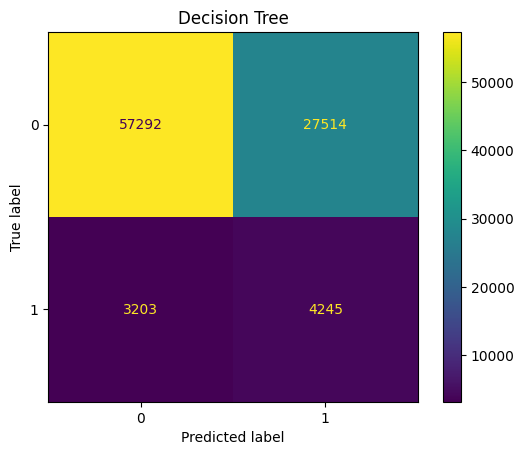

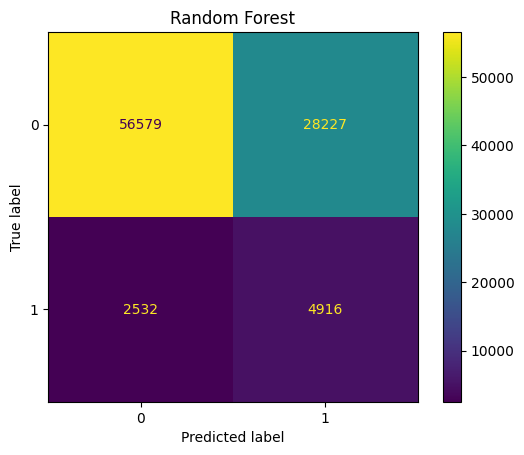

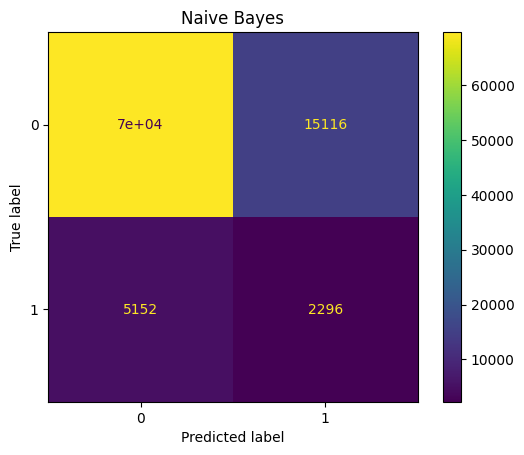

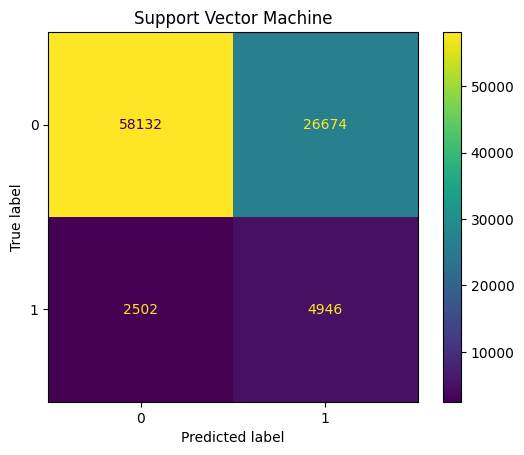

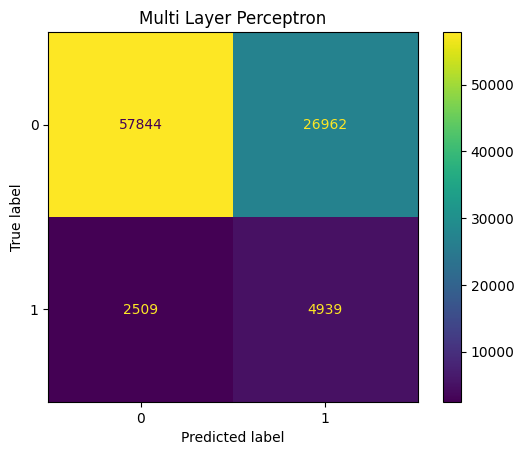

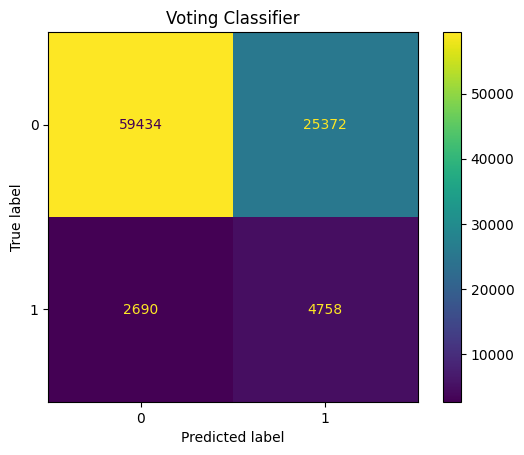

In [35]:
# Test over test set
print("[Macro Metrics]")
for name, model in optimized.items():
    y_pred = model.predict(x_test)
    #Macro scores
    macro_scores = precision_recall_fscore_support(y_test, y_pred, average="macro")
    print(name, "Precision: %f, Recall: %f, f1: %f" % macro_scores[:3])
    matrix = confusion_matrix(y_test, y_pred)
    matrix = ConfusionMatrixDisplay(confusion_matrix=matrix,
                                    display_labels=model.classes_)
    matrix.plot()
    matrix.ax_.set_title(name)


In [36]:
print("[Metrics for each class]")
for name, model in optimized.items():
    y_pred = model.predict(x_test)
    #Non-macro scores
    scores = precision_recall_fscore_support(y_test, y_pred)
    print(name, "Precision: %s, Recall: %s, f1: %s" % scores[:3])

[Metrics for each class]
Decision Tree Precision: [0.94705348 0.1336629 ], Recall: [0.67556541 0.56995166], f1: [0.78859746 0.21654296]
Random Forest Precision: [0.95716533 0.14832695], Recall: [0.66715798 0.66004296], f1: [0.78627264 0.24222118]
Naive Bayes Precision: [0.93116165 0.13186308], Recall: [0.82175789 0.30827068], f1: [0.8730457 0.1847144]
Support Vector Machine Precision: [0.95873602 0.15641999], Recall: [0.68547037 0.66407089], f1: [0.79939494 0.25319955]
Multi Layer Perceptron Precision: [0.95842792 0.15482273], Recall: [0.68207438 0.66313104], f1: [0.79697435 0.2510356 ]
Voting Classifier Precision: [0.9566995 0.1579157], Recall: [0.70082305 0.63882922], f1: [0.80901109 0.25323327]


## Conclusions
As it can be seen from the F1 scores and the images of the confusion matrices, the performances of the classifiers are not very good in recognizing people that will not give back the loans. This may derive from the following facts: 

1. the dataset is highly unbalanced, therefore from the examples of people that do not give back the money, the models are not able to extract sufficent knowledge for the classification task. In fact the f1 scores, if not averaged show that there are high scores for the class of people that give back their loans;  

2. the features created do not separate very well the two classes. This may depend from the fact that the data is from people that in many cases do not have an established credit history. Moreover, the data has been collected from low and medium income countris, therefore the chosen criteria (such as DTI and LTV) might be too strict;

3. the large amount of missing data has a negative impact on this task.